# **Image Captioning using Flickr 8k Dataset - ResNet**

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import to_categorical

import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import cv2, warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

## Data Ingestion

In [ ]:
from google.colab import files
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tithee","key":"c087435832068bc6d3546e02e51da1a6"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 62 Apr 24 09:22 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd


/content


In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

 99% 1.03G/1.04G [00:12<00:00, 67.4MB/s]
100% 1.04G/1.04G [00:12<00:00, 92.0MB/s]


In [ ]:
!unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed7be3.jpg  
  inflating: Images/2852982055_8112d0

## Visualization

In [ ]:
df=pd.read_table("captions.txt",delimiter=",")
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    40455 non-null  object
 1   caption  40455 non-null  object
dtypes: object(2)
memory usage: 632.2+ KB


In [ ]:
# Check null values
df.isna().sum()

image      0
caption    0
dtype: int64

In [ ]:
def display_image(temp_df):
  temp_df=temp_df.reset_index(drop=True)
  plt.figure(figsize=(20,20))
  n=0
  for i in range(temp_df.shape[0]):
    n=n+1
    plt.subplot(5,5,n)
    plt.subplots_adjust(hspace=1,wspace=0.3)
    img = cv2.imread(f"Images/{temp_df.image[i]}")
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("\n".join(wrap(temp_df.caption[i],30)))
    plt.axis("off")
  plt.show()

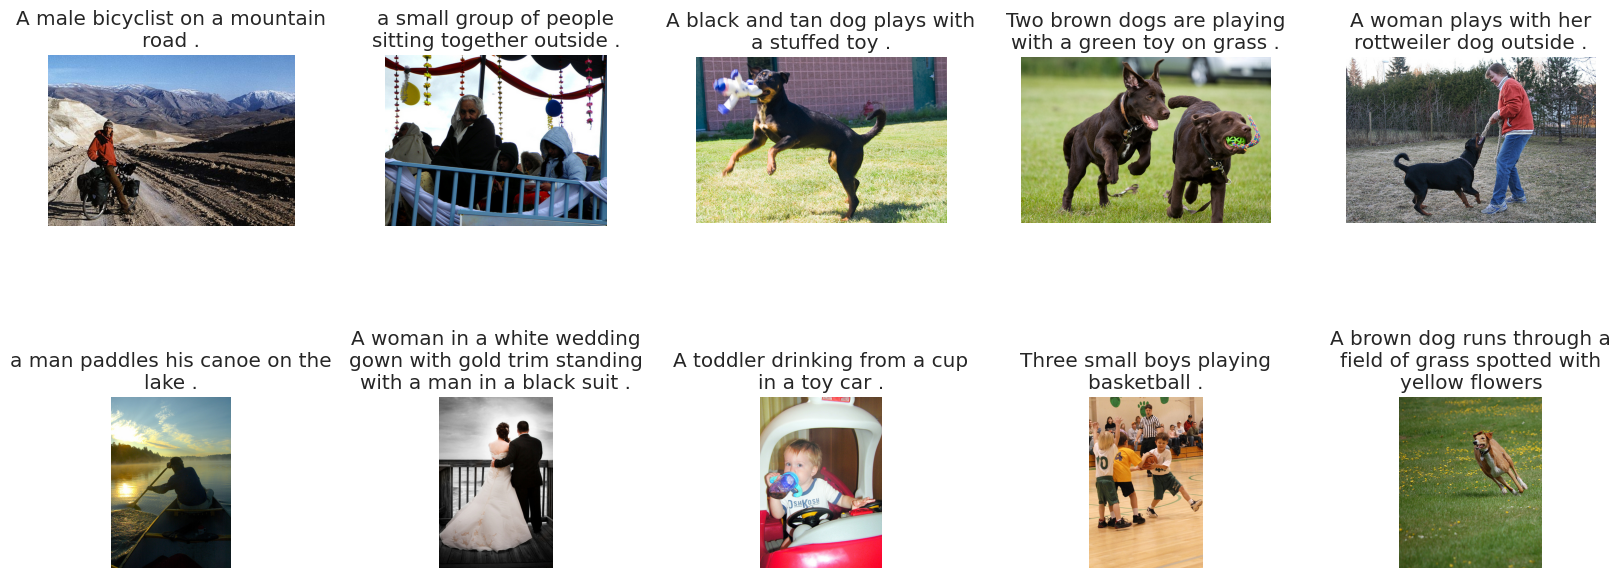

In [ ]:
display_image(df.sample(10))

## Pre-processing

In [ ]:
# Text Processing
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
# Transofrm the captions into lower case and remove punctuations
def process_nar(text):
    
    text = text.lower()  
    words = word_tokenize(text)

    a = [i for i in words if i.isalpha()]

    b = []
    for i in a:
        b.append(i)
    b = ' '.join(b)
    
    return b

In [ ]:
df['clean_caption'] = ''
for i, row in df.iterrows():
    df['clean_caption'][i] = 'startseq '+ process_nar(df['caption'][i])+' endseq'
df

,image,caption,clean_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,startseq a child in a pink dress is climbing u...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,startseq a girl going into a wooden building e...
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,startseq a little girl climbing into a wooden ...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,startseq a little girl climbing the stairs to ...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,startseq a little girl in a pink dress going i...
...,...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,startseq a man in a pink shirt climbs a rock f...
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .,startseq a man is rock climbing high in the ai...
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,startseq a person in a red shirt climbing up a...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .,startseq a rock climber in a red shirt endseq


In [ ]:
# Check the most frequently used word
text = ' '.join(df['clean_caption'].tolist())
tokens = nltk.word_tokenize(text)
freq_dist = nltk.FreqDist(tokens)
freq = pd.DataFrame(freq_dist.most_common())
freq.columns = ['word', 'freqency']
freq.head(20)

,word,freqency
0,a,62986
1,startseq,40455
2,endseq,40455
3,in,18974
4,the,18418
5,on,10743
6,is,9345
7,and,8851
8,dog,8136
9,with,7765


In [ ]:
# Check the total number of vocabulary used
caption_list = df.clean_caption.tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(caption_list)
vocab_size = len(tokenizer.word_index) + 1
print('Vocab Size: ', vocab_size)

Vocab Size:  8374


In [ ]:
tokenizer.texts_to_sequences([caption_list[6]])[0]

[2, 1, 15, 9, 8, 1, 9, 34, 10, 137, 82, 6, 5, 154, 3]

In [ ]:
# Check the length distribution of the captions
caption_lens = [len(caption.split()) for caption in caption_list]
max_caption = max(caption_lens)
min_caption = min(caption_lens)
print(f"Maximum Caption length : {max_caption}")
print(f"Minimum Caption length : {min_caption}")

Maximum Caption length : 36
Minimum Caption length : 3


In [ ]:
df['caption_len'] = caption_lens
df = df.sort_values(by='caption_len').reset_index(drop=True)
df

,image,caption,clean_caption,caption_len
0,2428275562_4bde2bc5ea.jpg,A,startseq a endseq,3
1,3640443200_b8066f37f6.jpg,a,startseq a endseq,3
2,1052358063_eae6744153.jpg,Two skateboarders .,startseq two skateboarders endseq,4
3,3504479370_ff2d89a043.jpg,Police gather .,startseq police gather endseq,4
4,3371266735_43150bce52.jpg,Men skiing .,startseq men skiing endseq,4
...,...,...,...,...
40450,2687328779_b4356dab16.jpg,"While one white dog is outside the pool , anot...",startseq while one white dog is outside the po...,34
40451,130211457_be3f6b335d.jpg,A girl in a red and black leotard with white w...,startseq a girl in a red and black leotard wit...,35
40452,1499495021_d295ce577c.jpg,A dark haired woman wearing a brown jacket and...,startseq a dark haired woman wearing a brown j...,35
40453,1472249944_d887c3aeda.jpg,A woman in an orange coat and jeans is squatti...,startseq a woman in an orange coat and jeans i...,35


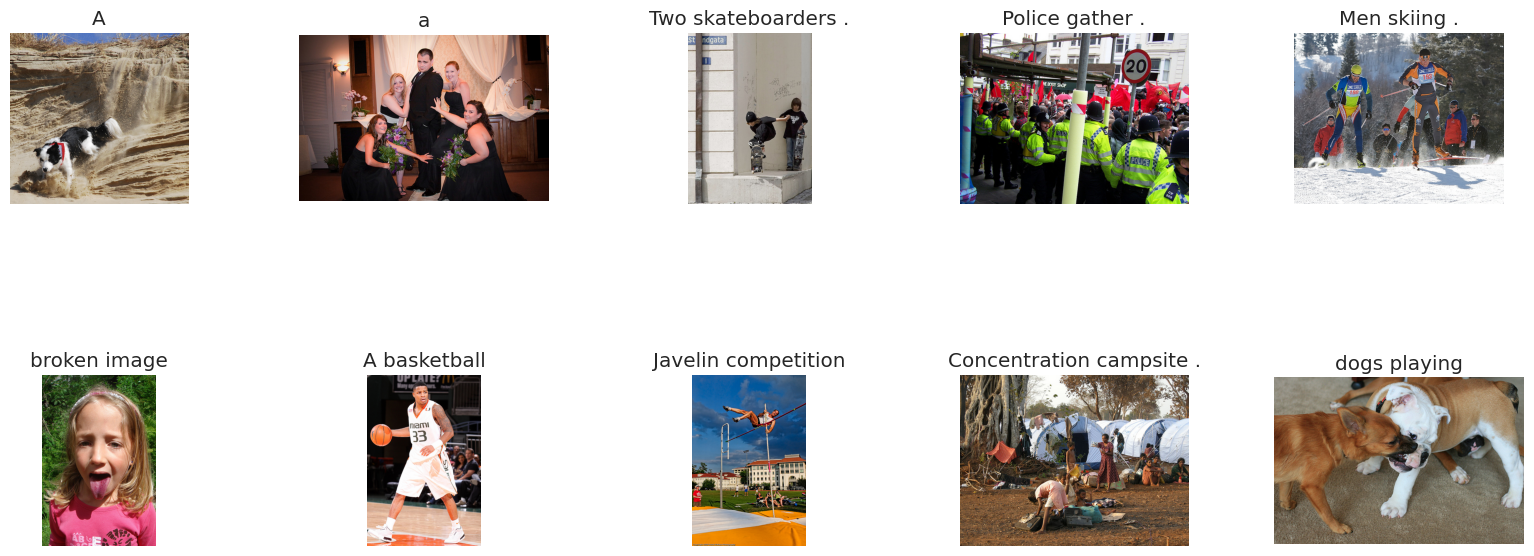

In [ ]:
# Check the images with the shortest captions
display_image(df.head(10))

In [ ]:
# Remove the rows with only one word in the captions since they do not describe the images correctly
df = df[df['caption_len']>1]
df

,image,caption,clean_caption,caption_len
0,2428275562_4bde2bc5ea.jpg,A,startseq a endseq,3
1,3640443200_b8066f37f6.jpg,a,startseq a endseq,3
2,1052358063_eae6744153.jpg,Two skateboarders .,startseq two skateboarders endseq,4
3,3504479370_ff2d89a043.jpg,Police gather .,startseq police gather endseq,4
4,3371266735_43150bce52.jpg,Men skiing .,startseq men skiing endseq,4
...,...,...,...,...
40450,2687328779_b4356dab16.jpg,"While one white dog is outside the pool , anot...",startseq while one white dog is outside the po...,34
40451,130211457_be3f6b335d.jpg,A girl in a red and black leotard with white w...,startseq a girl in a red and black leotard wit...,35
40452,1499495021_d295ce577c.jpg,A dark haired woman wearing a brown jacket and...,startseq a dark haired woman wearing a brown j...,35
40453,1472249944_d887c3aeda.jpg,A woman in an orange coat and jeans is squatti...,startseq a woman in an orange coat and jeans i...,35


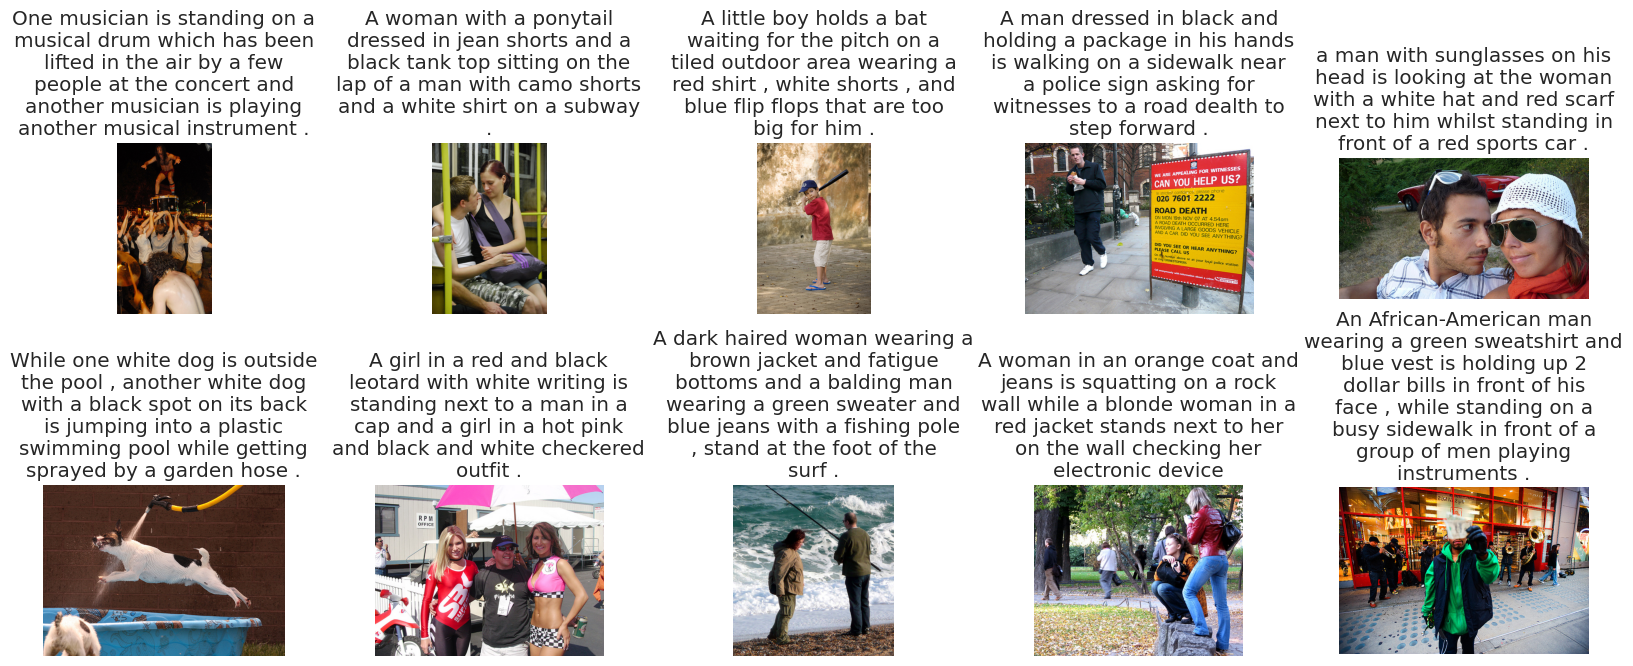

In [ ]:
# Check the images with the longest captions
display_image(df.tail(10))

<Axes: ylabel='caption_len'>

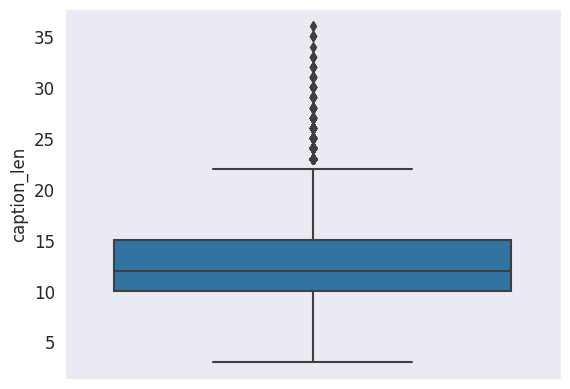

In [ ]:
# Visualize the caption length distribution with box plot and histogram
sns.boxplot(data=df,y='caption_len')

<Axes: xlabel='caption_len', ylabel='Count'>

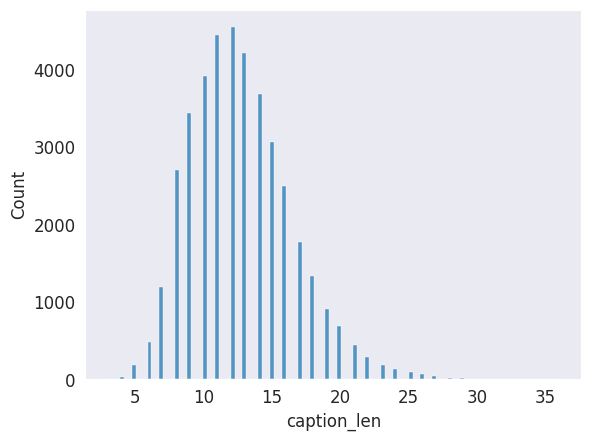

In [ ]:
sns.histplot(data=df,x='caption_len')

In [ ]:
df.columns

Index(['image', 'caption', 'clean_caption', 'caption_len'], dtype='object')

## Image Feature Extraction

In [ ]:
# ResNet50
model_resenet = ResNet50()
feature_img_resnet = Model(inputs=model_resenet.input, outputs=model_resenet.layers[-2].output)

features_resnet={}
from PIL import Image
import numpy as np

for image in tqdm(df['image'].unique().tolist()):
  img = Image.open("Images/"+image)
  img = img.resize((224, 224))
  img = np.array(img)
  img = img/255
  img=np.expand_dims(img,axis=0)
  feature = feature_img_resnet.predict(img, verbose=0)
  features_resnet[image]=feature


102967424/102967424 [==============================] - 1s 0us/step


100%|██████████| 8091/8091 [41:50<00:00,  3.22it/s]


In [ ]:
features_resnet[image].shape

(1, 2048)

In [ ]:
#Splitting train and test data
X_train_img, X_test_img, y_train, y_test = train_test_split(df['image'], df['clean_caption'], test_size=0.03, random_state=42)


In [ ]:
len(X_train_img)

39241

In [ ]:
len(X_test_img)

1214

In [ ]:
X_train_img

37561     948196883_e190a483b1.jpg
32076    3671935691_57bdd0e778.jpg
6225     2949762776_52ece64d28.jpg
17224    3280173193_98c2d6a223.jpg
10545    3347701468_bb0001b035.jpg
                   ...            
6265     3328535573_33c3cd5b59.jpg
11284    2330062180_355ccbceb5.jpg
38158     359082432_c1fd5aa2d6.jpg
860       265223847_636ba039c1.jpg
15795    2414986483_004936f84b.jpg
Name: image, Length: 39241, dtype: object

In [ ]:
features_resnet['2414986483_004936f84b.jpg'][0]

array([0.        , 0.        , 0.00641948, ..., 2.7751122 , 0.        ,
       0.        ], dtype=float32)

In [ ]:
y_train

37561    startseq a man is slouched near an atm while a...
32076    startseq a girl in a pink dress is jubilant wh...
6225     startseq two football teams play on the field ...
17224    startseq two women wrestle at the beach next t...
10545    startseq a young flag football team are huddle...
                               ...                        
6265     startseq men with camels gather on a beach endseq
11284    startseq a white dog is running through the sn...
38158    startseq a man and a dog are standing on a tre...
860      startseq person landing a yellow hanglider endseq
15795    startseq the little girl dances with a blues b...
Name: clean_caption, Length: 39241, dtype: object

## Model

In [ ]:
# Map input image, input sequence and output sequence
def data_generator(descriptions, features, tokenizer, max_length):
  while 1:
      for key in descriptions: 
          feature = features[key][0]
          input_image, input_sequence, output_word = create_sequences(tokenizer, max_length,descriptions[key], feature)
          yield [[input_image, input_sequence], output_word]
def create_sequences(tokenizer, max_length, desc, feature):
    X1, X2, y = list(), list(), list()
    for j in desc:
      seq = tokenizer.texts_to_sequences([j])[0]
      for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          X1.append(feature)
          X2.append(in_seq)
          y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [ ]:
# Map the image and caption
def caption_dictionary(Keys):
  image_map={}
  for i in Keys:
    if i in image_map:
      continue
    else:
      caption_lis=[]
      for j in df['clean_caption'][df.index[df['image']==i]]:
        caption_lis.append(j)
      image_map[i]=caption_lis
  return image_map

In [ ]:
[a,b],c = next(data_generator(caption_dictionary(X_train_img), features_resnet, tokenizer, max_caption))
a.shape, b.shape, c.shape

((83, 2048), (83, 36), (83, 8374))

In [ ]:
# Model for generating the caption
def basic_model(shape_,vocab_size, max_caption):

	input_image = Input(shape=(shape_,))
	input_image = Dropout(0.5)(input_image)
	dense_1 = Dense(256, activation='relu')(input_image)

	input_caption = Input(shape=(max_caption,))
	embed = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
	input_ = Dropout(0.5)(embed)
	dense_2 = LSTM(256)(input_)

	final_model= concatenate([dense_1, dense_2])
	decoder2 = Dense(256, activation='relu')(final_model)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)

	model = Model(inputs=[input_image, input_caption], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	return model

In [ ]:
[a,b],c = next(data_generator(caption_dictionary(X_train_img), features_resnet, tokenizer, max_caption))
a.shape, b.shape, c.shape

((83, 2048), (83, 36), (83, 8374))

In [ ]:
model_resnet=basic_model(2048,vocab_size,max_caption)
model_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 36)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 36, 256)      2143744     ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dropout_1 (Dropout)            (None, 36, 256)      0           ['embedding[1][0]']              
                                                                                            

In [ ]:
epochs=10
steps=500
for  i in range(epochs):
   model_resnet.fit(
        data_generator(caption_dictionary(X_train_img), features_resnet, tokenizer, max_caption),
        epochs=1,steps_per_epoch=steps,verbose=1)
   model_resnet.save('model_resnet'+str(i)+'.h5')

500/500 [==============================] - 194s 388ms/step - loss: 2.7365


In [ ]:
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from keras.models import load_model

In [ ]:
# Tranform the index to word and run the model to generate captions
def word_for_id(integer,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

def generate_caption(model,tokenizer,photo,max_length):
  in_text="startseq"
  for i in range(max_length):
    seq=tokenizer.texts_to_sequences([in_text])[0]
    seq=pad_sequences([seq],maxlen=max_length)
    yhat=model.predict([photo.reshape(1,-1),seq.reshape(1,-1)],verbose=0)
    yhat=np.argmax(yhat)
    word=word_for_id(yhat,tokenizer)
    if word is None:
      break
    in_text +=' '+word
    if word=='endseq':
      break
  return in_text



## Evaluation

In [ ]:
# Evaluate the model performance with BLEU
def evaluate_model(model,caption,photos,tokenizer,max_length):
  actual,predicted=list(),list()
  for key,caption in caption.items():
    yhat=generate_caption(model,tokenizer,photos[key],max_length)
    references=[d.split() for d in caption]
    actual.append(references)
    predicted.append(yhat.split())
  print('________________')
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [ ]:
# Evaluate model with test data
model_resnet_ = load_model('model_resnet9.h5')
x_test={}
for i in X_test_img:
  if i in x_test:
    continue
  else:
    x_test[i]=features_resnet[i][0]
evaluate_model(model_resnet_,caption_dictionary(X_test_img) ,x_test, tokenizer, max_caption)


________________
BLEU-1: 0.431249
BLEU-2: 0.260574


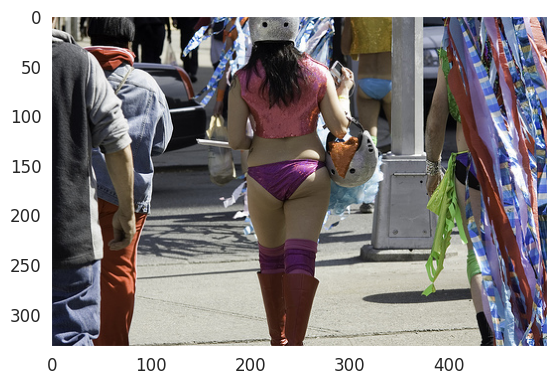

In [ ]:
# Sample image
img = cv2.imread(f"Images/447733067_09cfac3286.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
# Sample output
generate_caption(model_resnet_,tokenizer,features_resnet['447733067_09cfac3286.jpg'][0],max_caption)

'startseq a man in a bikini is standing in front of a woman in a blue shirt endseq'